In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt 

In [74]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        return x

In [75]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, mid_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(mid_channels + out_channels, out_channels, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=0)
        
    def forward(self, x, skip):
        x = self.up(x)
        # Skip connection
        x = torch.cat([x, F.interpolate(skip, x.shape[2:])], 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

In [76]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.enc1 = EncoderBlock(3, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=0),
            nn.ReLU(inplace=True)
        )
        
        self.dec1 = DecoderBlock(1024, 512, 512)
        self.dec2 = DecoderBlock(512, 256, 256)
        self.dec3 = DecoderBlock(256, 128, 128)
        self.dec4 = DecoderBlock(128, 64, 64)
        
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        
    def forward(self, x):
        s1 = self.enc1(x)
        s2 = self.enc2(s1)
        s3 = self.enc3(s2)
        s4 = self.enc4(s3)
        
        b = self.bottleneck(s4)
        
        d1 = self.dec1(b, s4)
        d2 = self.dec2(d1, s3)
        d3 = self.dec3(d2, s2)
        d4 = self.dec4(d3, s1)
        
        out = self.final_conv(d4)
        return out

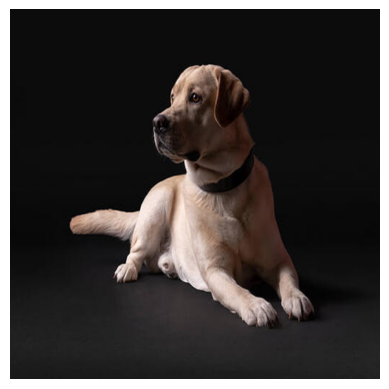

In [77]:
# Load and preprocess the image
img = Image.open('images/PP_DogImages_1_930x696.jpg').resize((572, 572))
# Display the image
plt.imshow(img)
plt.axis('off') 
plt.show()

In [87]:
# Get the raw output from the model
with torch.no_grad():
    raw_output = unet(img_tensor)
    
# Check the statistics of the raw output
print("Raw output statistics:", raw_output.min().item(), raw_output.max().item(), raw_output.mean().item())
output_probabilities = torch.sigmoid(raw_output).squeeze()
print("Sigmoid output statistics:", output_probabilities.min().item(), output_probabilities.max().item(), output_probabilities.mean().item())

Raw output statistics: -0.08732985705137253 -0.03573702648282051 -0.050572238862514496
Sigmoid output statistics: 0.478181391954422 0.49106672406196594 0.4873596429824829


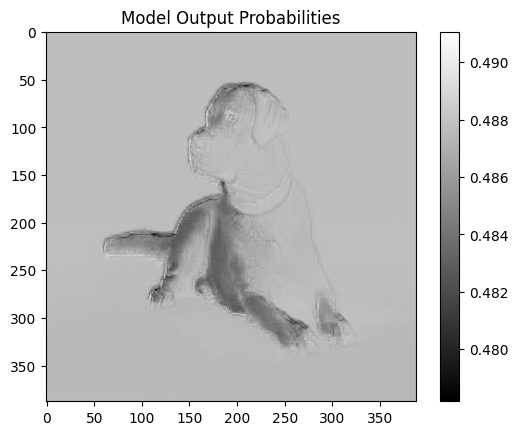

In [89]:
# Convert sigmoid output to NumPy array
output_probabilities_np = output_probabilities.cpu().numpy()

# Display the output probabilities as an image
plt.imshow(output_probabilities_np, cmap='gray')
plt.colorbar()
plt.title('Model Output Probabilities')
plt.show()

In [90]:
# Image Preprocessing
def preprocess_image(image_path, img_size):
    img = Image.open(image_path)
    img = img.resize(img_size)
    img_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = img_transform(img).unsqueeze(0)  # Add batch dimension
    return img_tensor

In [91]:
# Load the image and preprocess it
img_tensor = preprocess_image('images/PP_DogImages_1_930x696.jpg', (572, 572))

# Initialize the model
unet = UNet(num_classes=1)
unet.eval()  # Set the model to evaluation mode

# Load the model weights
# unet.load_state_dict(torch.load('path_to_your_model.pth'))

# Make predictions
with torch.no_grad():
    output = unet(img_tensor)

# Apply sigmoid activation
output_sigmoid = torch.sigmoid(output)

# Apply threshold to get binary map
threshold_value = 0.5
binary_map = (output_sigmoid > threshold_value).float()

# Remove the channel dimension and convert to numpy
binary_map_np = binary_map.squeeze().cpu().numpy()

# Convert to PIL Image and save
binary_map_pil = Image.fromarray((binary_map_np * 255).astype(np.uint8))
binary_map_pil.save('output_segmentation.png')
